<a href="https://colab.research.google.com/github/NegoitaAdrian18/Tensorflow_projects/blob/main/4_3_Transfer_Learning_with_TF_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check to see if i'm using a GPU

!nvidia-smi

Sun Aug 28 13:57:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Create helper functions

> Download helper functions from previous notebook

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-28 13:57:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-28 13:57:14 (98.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


### 101 Food classes: working with less data

> Obs || The data comes from the original Food 101 dataset but has been preprocessed using the image_data_modification notebook -> https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"


--2022-08-28 13:57:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   273MB/s    in 5.9s    

2022-08-28 13:57:23 (262 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there ?

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food

In [ ]:
# Set up data inputs

import tensorflow as tf

IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)             # Don't shuffle test data for prediction analysis




Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


**Train a big dog model with transfer learning on 10 % of 101 food classes**

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model 
* Build a headless (no top layers) Functional EfficientNetB0 backbond-model (we'll creaste our own output layer)

* Compile the model 
* Feature extract for 5 full passes ( 5 epochs on the train dataset and valid on 15% of the test data, to save epoch time)


In [ ]:
# Create checkpoint callback

# definesc prima oara locul unde voi salva checkpoint-ul
checkpoint_path = "101_classes_10_percent_data_model_chepoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)


In [ ]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    #preprocessing.Rescaling(1/225.)  # rescale inputs of images to between 0 & 1, required for models like ResNet
], name = 'data_augmentation')



In [ ]:
#Set up the base model and freeze its layers (this will extract features)


base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name='input_layer')
x  = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='ourput_layer')(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Summary of the model 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 ourput_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
from tensorflow.python import metrics
# Compile 
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Fit 
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps = int(0.15*len(test_data)), # validate on only 15% of test data
                                           callbacks = [checkpoint_callback])  

Epoch 1/5
237/237 [==============================] - 93s 316ms/step - loss: 3.4665 - accuracy: 0.2475 - val_loss: 2.6628 - val_accuracy: 0.4039
Epoch 2/5
237/237 [==============================] - 61s 255ms/step - loss: 2.3446 - accuracy: 0.4646 - val_loss: 2.2093 - val_accuracy: 0.4778
Epoch 3/5
237/237 [==============================] - 58s 241ms/step - loss: 1.9738 - accuracy: 0.5279 - val_loss: 2.0075 - val_accuracy: 0.5053
Epoch 4/5
237/237 [==============================] - 51s 212ms/step - loss: 1.7625 - accuracy: 0.5691 - val_loss: 1.9634 - val_accuracy: 0.5029
Epoch 5/5
237/237 [==============================] - 49s 203ms/step - loss: 1.6120 - accuracy: 0.6058 - val_loss: 1.9045 - val_accuracy: 0.5106


In [ ]:
# Evaluate on the whole test dataset

feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 68s 86ms/step - loss: 1.6014 - accuracy: 0.5802


[1.6013740301132202, 0.5801980495452881]

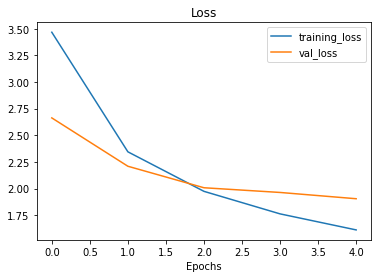

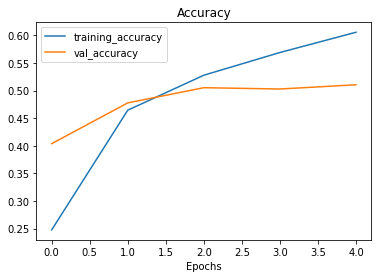

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

OBS || While validation loss is increasing, while training losses are decreasing, so that means this model is identifying patterns in the training data to well and isn't generalizing well to unseen data because what is this validation loss it's the validation data, which is my test data set, which the model doesnt train on that (this is unseen data) 

Clc || The 2 curves should be very similar to each other. If not, it may suggest that the model is overfitting, perfoming too well on the training data and not generalizing the unseen data.

**Fine-tuning**

In [ ]:
# Unfreeze all of the layers in the base model 

base_model.trainable = True

# Refreeze every layer except the last 5 
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tunning )

model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0001), # THe learning rate dictate how much your model's paterns should update to try and improve the loss function
              metrics = ['accuracy'])

# What layers in the model are trainable ?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
ourput_layer True


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Check which layers are trainable in the base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)
  

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
#  Fine - tune for 5 more epochs
fine_tune_epochs = 10 # model has already 5 done epochs

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1]) # am setat sa continue de la a 5-a epocha (practic de unde a ramas)

Epoch 5/10
237/237 [==============================] - 54s 199ms/step - loss: 1.3654 - accuracy: 0.6500 - val_loss: 1.9027 - val_accuracy: 0.5037
Epoch 6/10
237/237 [==============================] - 46s 193ms/step - loss: 1.2310 - accuracy: 0.6762 - val_loss: 1.8645 - val_accuracy: 0.5207
Epoch 7/10
237/237 [==============================] - 41s 173ms/step - loss: 1.1507 - accuracy: 0.6924 - val_loss: 1.8545 - val_accuracy: 0.5238
Epoch 8/10
237/237 [==============================] - 42s 177ms/step - loss: 1.0776 - accuracy: 0.7156 - val_loss: 1.8016 - val_accuracy: 0.5328
Epoch 9/10
237/237 [==============================] - 42s 175ms/step - loss: 1.0149 - accuracy: 0.7315 - val_loss: 1.8503 - val_accuracy: 0.5230
Epoch 10/10
237/237 [==============================] - 40s 167ms/step - loss: 0.9700 - accuracy: 0.7383 - val_loss: 1.8608 - val_accuracy: 0.5246


In [ ]:
# Evaluate on the wholetest data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results


790/790 [==============================] - 61s 77ms/step - loss: 1.6014 - accuracy: 0.5802


[1.6013740301132202, 0.5801980495452881]

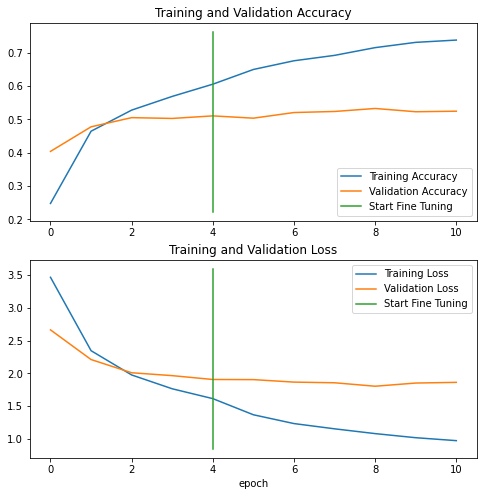

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model 
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

 ### **Saving and loading the model**

 To use the model in an external application, we'll need to save it and export it.

 

In [ ]:
# Save the fine_tuning model
model.save("drive/MyDrive/Tensorflow_curs/101_food_classes_10_percent_saved_model")


In [ ]:
# LOad and evaluate saved model
model = tf.keras.models.load_model("drive/MyDrive/Tensorflow_curs/101_food_classes_10_percent_saved_model")

In [ ]:
# Evaluate laoded model and compare performance to pre-saved model
loaded_model_results = model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 65s 81ms/step - loss: 1.6014 - accuracy: 0.5802


[1.6013740301132202, 0.5801980495452881]

In [ ]:
# The resuls from the loaded_model should be very similar to the results of "all_classes_10_percent_fine_tune_results"
all_classes_10_percent_fine_tune_results

[1.6013740301132202, 0.5801980495452881]

## # Evaluate the performance of the model acorss all different classes

- make some predictions,
- visualize them,
- find out which predictions were the most wrong


In [ ]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


--2022-08-28 14:56:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  27.2MB/s    in 1.6s    

2022-08-28 14:56:08 (27.2 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Instantiate the model 
# Load in saved model 
modell = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate the loaded model ( the one that i just downloaded on test data)

results_downloaded_modell = model.evaluate(test_data)
results_downloaded_modell

790/790 [==============================] - 60s 76ms/step - loss: 1.6014 - accuracy: 0.5802


[1.6013740301132202, 0.5801980495452881]

## Making predictions with the trained model

In [ ]:
# Make predicitons with model 
preds_probes = modell.predict(test_data, verbose=1) # set verbosity to see how long is left


790/790 [==============================] - 63s 78ms/step


In [ ]:
# How many predictions are there ?
len((preds_probes))

25250

In [ ]:
# Shape of the predictions
preds_probes.shape

(25250, 101)

In [ ]:
# See what the first 10 predictions look like 
preds_probes[:10]

array([[5.9541952e-02, 3.5742082e-06, 4.1376974e-02, ..., 1.4138680e-09,
        8.3530831e-05, 3.0897511e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780576e-04, ..., 5.4286946e-05,
        7.8362811e-12, 9.8466213e-10],
       [9.5925879e-01, 3.2533622e-05, 1.4866935e-03, ..., 7.1891071e-07,
        5.4397117e-07, 4.0275776e-05],
       ...,
       [4.7313267e-01, 1.2931186e-07, 1.4805621e-03, ..., 5.9750048e-04,
        6.6968976e-05, 2.3469211e-05],
       [4.4571947e-02, 4.7265419e-07, 1.2258486e-01, ..., 6.3498483e-06,
        7.5318626e-06, 3.6778681e-03],
       [7.2438961e-01, 1.9249808e-09, 5.2310945e-05, ..., 1.2291385e-03,
        1.5792746e-09, 9.6395852e-05]], dtype=float32)

In [ ]:
# What does the first prediciton probability array look like ?
preds_probes[0], len(preds_probes[0]), sum(preds_probes[0])

(array([5.95419519e-02, 3.57420822e-06, 4.13769744e-02, 1.06605547e-09,
        8.16142798e-09, 8.66396554e-09, 8.09271114e-07, 8.56526640e-07,
        1.98590151e-05, 8.09776168e-07, 3.17277427e-09, 9.86738314e-07,
        2.85322167e-04, 7.80493392e-10, 7.42300879e-04, 3.89163397e-05,
        6.47404340e-06, 2.49773279e-06, 3.78911318e-05, 2.06783056e-07,
        1.55384496e-05, 8.15069370e-07, 2.62305412e-06, 2.00106655e-07,
        8.38272967e-07, 5.42159842e-06, 3.73909279e-06, 1.31505820e-08,
        2.77614314e-03, 2.80519198e-05, 6.85624113e-10, 2.55748309e-05,
        1.66888960e-04, 7.64069974e-10, 4.04528371e-04, 1.31506335e-08,
        1.79573772e-06, 1.44482158e-06, 2.30628997e-02, 8.24667779e-07,
        8.53657696e-07, 1.71386114e-06, 7.05252342e-06, 1.84021669e-08,
        2.85532963e-07, 7.94833795e-06, 2.06815525e-06, 1.85251338e-07,
        3.36196422e-08, 3.15225538e-04, 1.04109122e-05, 8.54483574e-07,
        8.47418606e-01, 1.05554345e-05, 4.40945854e-07, 3.740414

> The model outputs a prediction probability array (with N numbers of variables, where N is the number of classes ) for each sample passed to the predict method.

In [ ]:
 # We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of predictions probabilities for sample 0: {len(preds_probes[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probes[0]}")
print(f"The classes with the highest predicted probability by the model for sample 0: {preds_probes[0].argmax()}")


Number of predictions probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95419519e-02 3.57420822e-06 4.13769744e-02 1.06605547e-09
 8.16142798e-09 8.66396554e-09 8.09271114e-07 8.56526640e-07
 1.98590151e-05 8.09776168e-07 3.17277427e-09 9.86738314e-07
 2.85322167e-04 7.80493392e-10 7.42300879e-04 3.89163397e-05
 6.47404340e-06 2.49773279e-06 3.78911318e-05 2.06783056e-07
 1.55384496e-05 8.15069370e-07 2.62305412e-06 2.00106655e-07
 8.38272967e-07 5.42159842e-06 3.73909279e-06 1.31505820e-08
 2.77614314e-03 2.80519198e-05 6.85624113e-10 2.55748309e-05
 1.66888960e-04 7.64069974e-10 4.04528371e-04 1.31506335e-08
 1.79573772e-06 1.44482158e-06 2.30628997e-02 8.24667779e-07
 8.53657696e-07 1.71386114e-06 7.05252342e-06 1.84021669e-08
 2.85532963e-07 7.94833795e-06 2.06815525e-06 1.85251338e-07
 3.36196422e-08 3.15225538e-04 1.04109122e-05 8.54483574e-07
 8.47418606e-01 1.05554345e-05 4.40945854e-07 3.74041447e-05
 3.53061914e-05 3.24890389e-05 6.73146787e

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label 
pred_classes = preds_probes.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have? 
len(pred_classes)

25250

> Now we've got a predictions array of all of our models predictions, to evaluate them, i need to compare them to the original test dataset labels. 


In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# Tho get our test labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #for ex. currently test labels look like : [0,0,0,1,0,...,0,0], we want to index value where the "1" occures
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_lebels are there 
len(y_labels) # should be one for each image => 25250

25250

## Evaluating our model;s predictions 

> One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score. 


In [ ]:
results_downloaded_modell


[1.6013740301132202, 0.5801980495452881]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with 
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metrics come close to our model;s evaluate results? 
import numpy as np
np.isclose(results_downloaded_modell[1], sklearn_accuracy)

False

> Obs - trebuie sa revad modelul, ar fi trebuit sa obtin True 

In [ ]:
# Creating a confusion matrix for our model's 101 different classes